# Diffusion Matching

This notebook will serve as a testing venue for matching an Epstein-Plesset-like model of bubble growth in a supersaturated liquid with a concentration-dependent diffusion model of CO2 concentration in sheath flow.

The basis for the diffusion model will come from `20200905_diffn_in_out_vs_Qi.ipynb` and the basis for the bubble growth model will come from the model used in `analytics.fit_growth_to_pt()`, as in `20201010_v360_co2_c5_11184...ipynb`.

## SETUP

In [3]:
# SETUP

# adds custom libraries to path
import sys
sys.path.append('src/')
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# imports custom libraries
import polyco2
import diffn
import flow
import bubble
import bubbleflow
import analytics as an
import finitediff as fd

# plotting
import plot.diffn as pltd
import plot.bubble as pltb
import plot.genl as pltg

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload


# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken in videos of effect of flow rate on 20200905_80bar [m]
d = 0.096

# bubble growth model parameters
dt = 1E-12 # [s]
R_nuc = 5E-6 # [m] arbitrary bubble size for comparing models

# grid parameters
R_o = 150E-6 # outer radius [m]

# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = 'input/1k3f_22c.csv'

# equation of state data
eos_co2_file = 'input/eos_co2_22-0C.csv'


# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

### Flow Parameters

In [19]:
# computes inner stream radius [m] and velocity [m/s]
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM - dp
# nucleation time [s]
t_nuc = d/v

### Epstein-Plesset Results

Collects parameters used for Epstein-Plesset model and computes bubble properties, including the concentration gradient at the surface for comparison to the numerical models.

In [5]:
reload(bubble)

# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# Epstein-Plesset solution for comparison
t_eps, m, D, p, p_bub, if_tension, c_s, c_bulk, R_eps, rho_co2 = bubble.grow(t_nuc, *eps_params)
props_list_eps = (R_eps, m, p, p_bub, rho_co2, if_tension)

# uses 2nd-order Taylor stencil to compute concentration gradient at the surface of the bubble
dcdr_eps = bubble.calc_dcdr_eps(c_bulk, c_s, R_eps, D, np.asarray(t_eps) - t_nuc)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:223: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


# ANALYSIS

### Compare Fully Numerical and Epstein-Plesset with Numerical Time-stepping

In [6]:
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N = 400
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]
dt_max = 0.5*(R_max/N)**2/D_max

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max)

In [ ]:
# plotting
props_list_num = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_num, x_log=True, title='Numerical')

reload(pltd)
n_plot = 10
r_arr = diffn.make_r_arr_lin(N, R_max)
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

**Note that when plotting on log(r) scale, the line from r = 0 to the first finite value of r will look horizontal because r = 0 is infinitely far away on a log scale.**


##### Epstein-Plesset Model

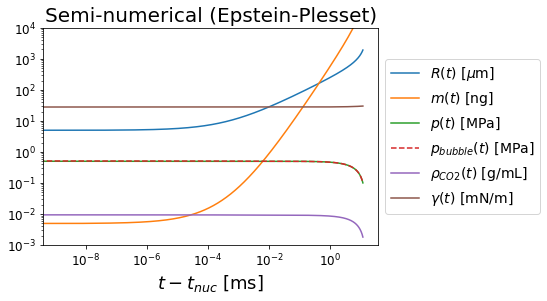

In [8]:
ax = pltb.all_props(t_eps, t_nuc, props_list_eps, x_log=True, title='Semi-numerical (Epstein-Plesset)')

Compare the difference between numerical Epstein-Plesset and analytical.

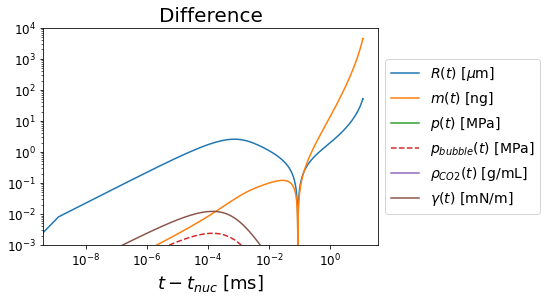

In [9]:
props_list_diff = [np.abs(np.interp(t_eps, t_num, np.asarray(props_list_num[i])) - np.asarray(props_list_eps[i])) \
                   for i in range(len(props_list_num))]
ax = pltb.all_props(t_eps, t_nuc, props_list_diff, x_log=True, title='Difference')

Text(0.5, 1.0, 'Fractional Error in Radius, N = 400')

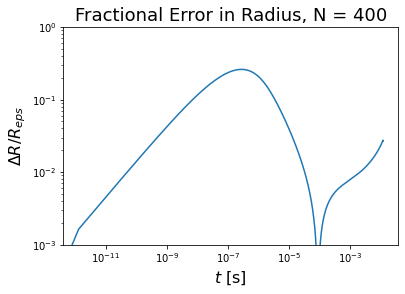

In [10]:
ax = pltd.R_diff(t_eps, props_list_eps[0], t_num, props_list_num[0])
ax.set_title('Fractional Error in Radius, N = {0:d}'.format(N), fontsize=t_fs)

Difference in radius at the end is about 200 um. Seems negligibly affected by N (compared N = 50 and N = 200 @ R_max = 100 um).

For R_max = 200 um (N = 400 to have same grid spacing), difference in radius is still about 200 um at the end.

The diffusivity D and bulk concentration c_bulk are identical for both cases, as expected.

## Compare Difference in Concentration Gradient at Bubble Interface

Plotting the analytical result for the concentration profile in the bulk is challenging due to improper integrals without an explicit form. Instead, I will plot the concentration gradient at the bubble interface, which has an explicit form in the Epstein-Plesset solution,

\begin{align}
\left( \frac{\partial c}{\partial r} \right)_R &= (c_B - c_s) \left[\frac{1}{R} + \frac{1}{\sqrt{\pi D t}} \right] \\
\end{align}

In [11]:
reload(an)
# list of N values to consider
N_list = [50, 100, 200, 400]
dt_max_list = None

t_eps, dcdr_eps, t_num_list, dcdr_num_list = an.calc_dcdr_eps_fix_D(N_list, R_max, t_nuc, eps_params, 
                                                                    dt_max_list=dt_max_list)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:544: RuntimeWarning: divide by zero encountered in double_scalars
  res1  = R - ( 3/(4*np.pi)*(m/f_rho_co2(p_bub)) )**(1/3.)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:204: RuntimeWarning: invalid value encountered in sqrt
  1/np.sqrt(np.pi*D*(np.asarray(t))))


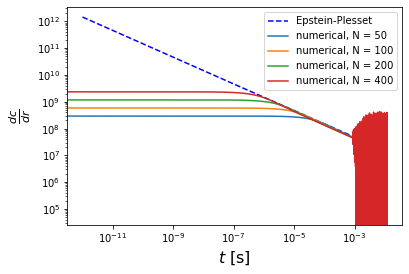

In [13]:
# plots results
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_eps, 'b--', label='Epstein-Plesset')

for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, label='numerical, N = {0:d}'.format(N))


ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


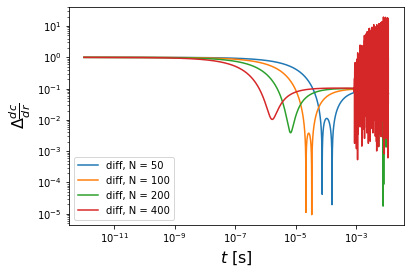

In [14]:
# plots difference
# plots results
fig = plt.figure()
ax = fig.add_subplot(111)

for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    dcdr_diff = np.abs(np.interp(t_eps, t_num, dcdr_num) - np.asarray(dcdr_eps)) / np.asarray(dcdr_eps)
    ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_diff, label='diff, N = {0:d}'.format(N))


ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\Delta \frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

### Add Cap to Time Step to Prevent Unstable Oscillations at Small Grid Spacings

Must make sure time step is smaller than diffusive time scale between grid spacings or else the system will be prone to oscillations that over-correct themselves.

In [15]:
reload(an)
# list of N values to consider
N_list = [50, 100, 200, 400]
dt_max_list = [0.5*(R_max/N)**2/D for N in N_list] # dt < half of diffusive time scale [s]

t_eps, dcdr_eps, t_num_list, dcdr_num_list = an.calc_dcdr_eps_fix_D(N_list, R_max, t_nuc, eps_params, 
                                                                    dt_max_list=dt_max_list)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:194: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\analytics.py:38: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(val_arr - ref_arr) / ref_arr


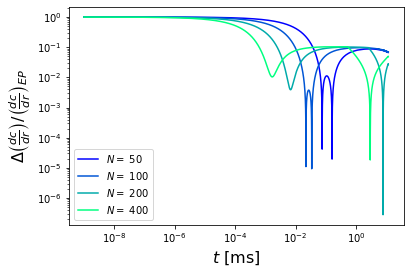

In [17]:
# PLOTS DIFFERENCE IN DC/DR AT BUBBLE SURFACE
# computes difference in dc/dr for each value of N
dcdr_diff_list = []
label_list = []
for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    dcdr_diff_list += [an.calc_diff(t_eps, dcdr_eps, t_num, dcdr_num)]
    label_list += [r'$N =$' + ' {0:d}'.format(N)]

# plots difference
_ = plot_dcdr_diff(t_eps, dcdr_diff_list, label_list)

Limiting the time step successfully stopped the oscillations! Increasing $N$ now improves the accuracy.

Further improvements in accuracy will need to resolve the interface more sharply. This would be done best by a logarithmically spaced grid. The current algorithm would need to be modified to accommodate an unevenly spaced grid.

## Adjust Spatial Resolution During Computation

Based on the above results, a fine grid is most beneficial at early times, but a coarser grid seems to give more accurate results (in addition to permitting longer time steps without becoming unstable) at later times. I will utilize this behavior by coarsening the grid for the radius $r$ by removing every other point once there are at least 10 points resolving the concentration gradient at the surface of the bubble (10 is just a guess for now).

In [105]:
reload(polyco2)
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N0 = 800
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]
dt_max = 0.5*(R_max/N0)**2/D_max
half_grid = True

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.num_vary_D(t_nuc, eps_params, R_max, N0, dc_c_s_frac, dt_max=dt_max, 
                                                              half_grid=half_grid, D_fn=fixed_D)

halving grid
halving grid
4.0
halving grid
halving grid
4.0
halving grid
halving grid
4.0
halving grid
halving grid
4.0


ValueError: x and y must have same first dimension, but have shapes (801,) and (401,)

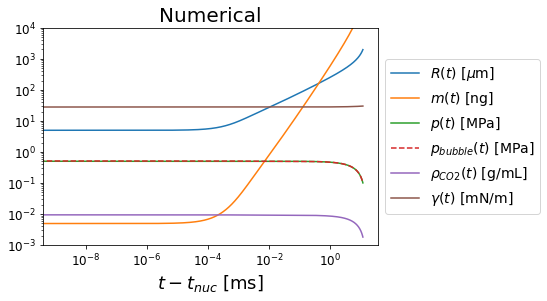

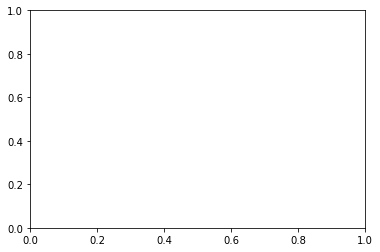

In [102]:
reload(pltd)
# plot
r_arr_list = [diffn.make_r_arr_lin(int(R_max/dr), R_max) for dr in dr_list]
n_plot = 8
ax1, ax2 = plot_bubble_sheath(R, m, p, p_bub, rho_co2, if_tension, t_num, t_nuc, t_flow, 
                              r_arr_list, c, R_max, v, c_bulk, n_plot)

### Compare Numerical with Grid-halving to Semi-numerical Epstein-Plesset Model

In [103]:
# uses 2nd-order Taylor stencil
dcdr_num = [fd.dydx_fwd_2nd(c[i][0], c[i][1], c[i][2], dr_list[i]) \
                    for i in range(len(c))]

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\analytics.py:38: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(val_arr - ref_arr) / ref_arr


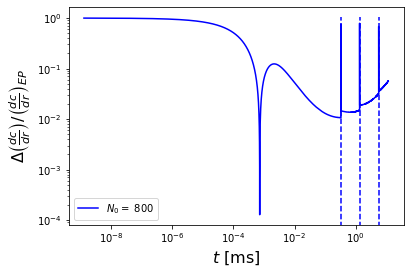

In [104]:
reload(an)

# finds times when halving took place
dr_diff = np.diff(dr_list)
i_halved = np.where(dr_diff > 0)[0]
t_halved_list = [[t_flow[i]-t_nuc for i in i_halved]]

# plots difference
dcdr_diff_list = [an.calc_diff(t_eps, dcdr_eps, t_num, dcdr_num)]
label_list = [r'$N_0 =$' + ' {0:d}'.format(N0)]
ax = plot_dcdr_diff(t_eps, dcdr_diff_list, label_list, t_halved_list)

### Streamline Comparison of dc/dr

Use function to compute $\left(\frac{dc}{dr}\right)_{r=0}$ under different conditions and plot difference from Epstein-Plesset result.

In [35]:
reload(bubbleflow)

# fixed inputs
D_fn = diffn.fixed_D

# varied inputs
# 1) N = 50 (2) N = 800 (3) N = 800 with grid halving
N_ = [50, 200, 800, 3200]
half_grid_ = [True, True, True, True]
dt_max_ = [0.5*(R_max/N)**2/D_max for N in N_]

# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(N_)
# groups inputs for each function
num_input_list = [(t_nuc, eps_params, R_max, N_[i], dc_c_s_frac, dt_max_[i], D_fn, half_grid_[i]) for i in range(len(N_))]

In [24]:
reload(bubbleflow)
reload(an)
dcdr_diff_list, dr_list_list, t_flow_list, raw_vals_list = an.compare_dcdr(num_input_list, num_fn_list, t_eps, dcdr_eps)

Computing <function num_vary_D at 0x0000015BCDE5E268>
halving grid
halving grid


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\analytics.py:38: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(val_arr - ref_arr) / ref_arr


Computing <function num_vary_D at 0x0000015BCDE5E268>
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
Computing <function num_vary_D at 0x0000015BCDE5E268>
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
Computing <function num_vary_D at 0x0000015BCDE5E268>
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid


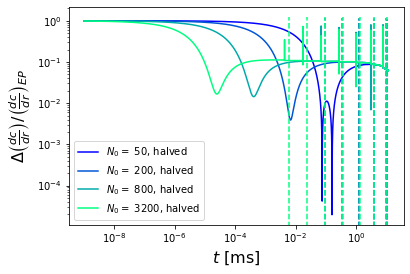

In [25]:
# creates labels
label_list = []
# stores times at which grid was halved 
t_halved_list = []

for N, half_grid, dr_list in zip(N_, half_grid_, dr_list_list):
    label = r'$N_0 =$' + ' {0:d}'.format(N)
    if half_grid:
        label += ', halved'
    label_list += [label]
    
    # times at which the grid was halved
    dr_diff = np.diff(dr_list)
    i_halved = np.where(dr_diff > 0)[0]
    t_halved_list += [[t_flow[i]-t_nuc for i in i_halved]]
    
ax = plot_dcdr_diff(t_eps, dcdr_diff_list, label_list, t_halved_list)

# ax.set_xlim([0.5, 15])

No correlation between halving the grid (vertical dashed lines) and sharp increases in the fractional deviation of the concentration gradient. Not sure what the cause of these spikes is.

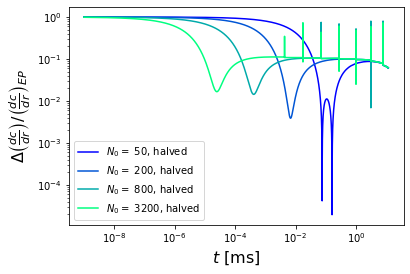

In [26]:
ax = plot_dcdr_diff(t_eps, dcdr_diff_list, label_list)

To help figure out the cause of the spikes in the fractional deviation of the concentration gradient for high values of $N$, I will plot the concentration gradients separately.

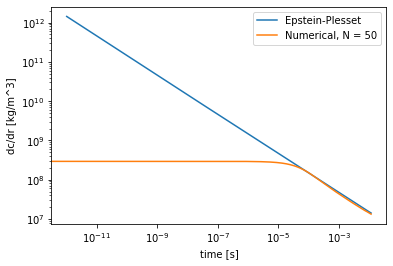

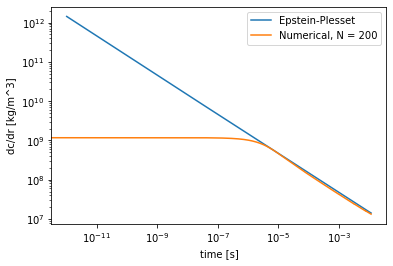

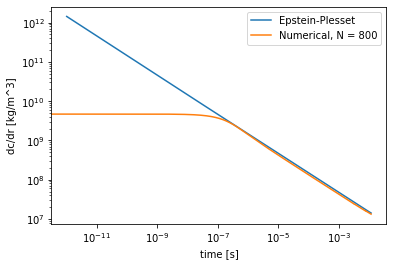

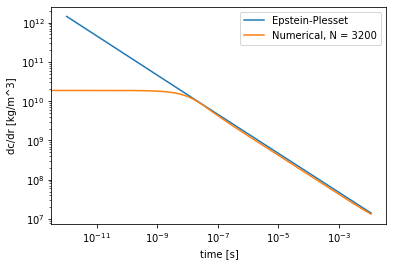

In [27]:
import scipy.signal

for i, raw_vals in enumerate(raw_vals_list):
    t_ref, dcdr_ref, t_num, dcdr_num = raw_vals
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(np.asarray(t_ref) - t_ref[0], dcdr_ref, label='Epstein-Plesset')
    ax.plot(np.asarray(t_num) - t_num[0], scipy.signal.medfilt(dcdr_num), label='Numerical, N = {0:d}'.format(N_[i]))
    ax.set_xlabel('time [s]')
    ax.set_ylabel('dc/dr [kg/m^3]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.legend()

A median filter completely eliminates the spikes, so I know that they are individual time steps and therefore likely have little effect on the final result. However, it would be good to eliminate them. Maybe I can set a limit on the deviation in dc/dr?

It's also clear that the numerical method *underestimates* the flux into the bubble, likely because the concavity of the concentration profile is negative at the bubble surface ($r = 0$).

### Compare Radius

In [38]:
reload(bubbleflow)

# fixed inputs
D_fn = fixed_D

# varied inputs
# 1) N = 50 (2) N = 800 (3) N = 800 with grid halving
N_ = [50, 200, 800]
half_grid_ = [False, False, False] #[True, True, True, True]
dt_max_ = [0.5*(R_max/N)**2/D_max for N in N_]

# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(N_)
# groups inputs for each function
num_input_list = [(t_nuc, eps_params, R_max, N_[i], dc_c_s_frac, dt_max_[i], D_fn, half_grid_[i]) for i in range(len(N_))]

In [39]:
reload(an)
R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_vary_D at 0x0000015BCDE5E9D8>
Computing <function num_vary_D at 0x0000015BCDE5E9D8>
Computing <function num_vary_D at 0x0000015BCDE5E9D8>


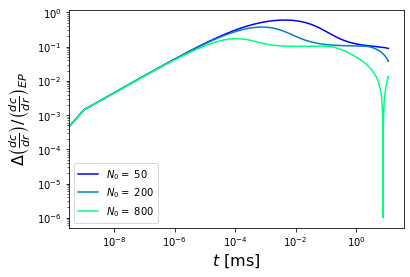

In [43]:
# creates labels
label_list = []
# stores times at which grid was halved 
t_halved_list = []

for N, half_grid, dr_list in zip(N_, half_grid_, dr_list_list):
    label = r'$N_0 =$' + ' {0:d}'.format(N)
#     if half_grid:
#         label += ', halved'
    label_list += [label]
    
    # times at which the grid was halved
    dr_diff = np.diff(dr_list)
    i_halved = np.where(dr_diff > 0)[0]
    t_halved_list += [[t_flow[i]-t_nuc for i in i_halved]]
    
ax = plot_dcdr_diff(t_eps, R_diff_list, label_list, t_halved_list)

(0.001, 1)

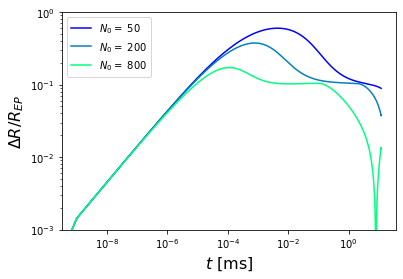

In [45]:
ax = plot_dcdr_diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])

Looking pretty good at $N_0 = 3200$. I wish I could lower the plateau at 10% error. It doesn't seem like the spikes in $\frac{dc}{dr}$ have a significant effect on the discrepancy in the radius.

## Logarithmic Grid Spacing

In [130]:
%%time

reload(diffn)
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N = 18
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]

# computes smallest length scale in grid [m]
r_arr_log = diffn.make_r_arr_log(N, R_max)
d = r_arr_log[1] - r_arr_log[0]

# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max, pts_per_grad=10,
                                                             grid_fn=diffn.make_r_arr_log, half_grid=True,
                                                             dcdt_fn=diffn.calc_dcdt_sph_fix_D_nonuniform)

Wall time: 12min 9s


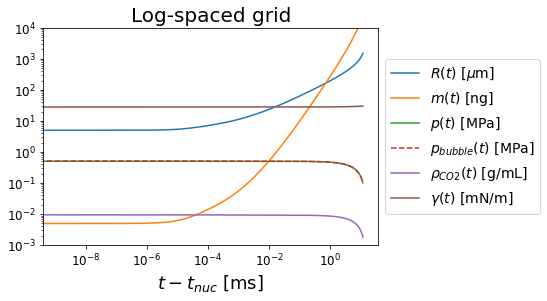

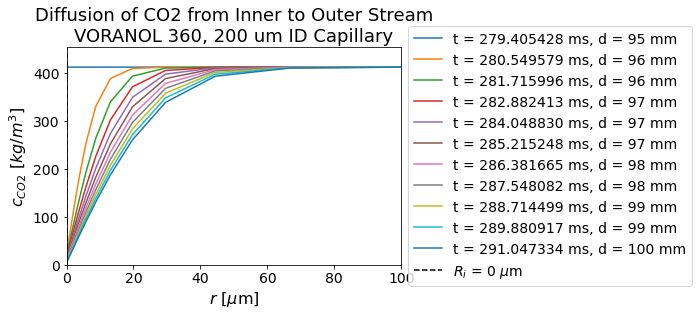

In [131]:
# plotting
props_list_log = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_log, x_log=True, title='Log-spaced grid')

reload(pltd)
n_plot = 10
r_arr = diffn.make_r_arr_log(N, R_max)
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

Text(0.5, 1.0, 'Fractional Error in Radius, N = 18')

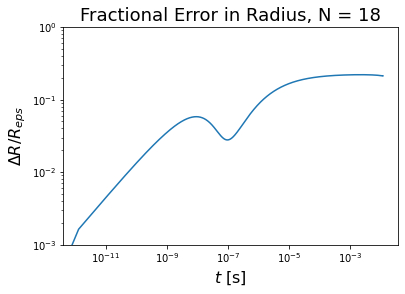

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111)

R_eps = np.asarray(props_list_eps[0])
R_log = np.interp(t_eps, t_num, np.asarray(props_list_log[0]))
R_frac_diff = np.abs(R_eps - R_log) / R_eps

ax.plot(np.asarray(t_eps) - t_eps[0], R_frac_diff)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$t$ [s]', fontsize=ax_fs)
ax.set_ylabel(r'$\Delta R/ R_{eps}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('Fractional Error in Radius, N = {0:d}'.format(N), fontsize=t_fs)

## Incorporate Concentration-dependence of Diffusivity

First, I will make sure that the new function that incorporates the concentration dependence of diffusivity matches the previous function with fixed diffusivity when I artificially fix the diffusivity.

In [ ]:
reload(polyco2)
reload(bubble)
reload(diffn)
reload(bubbleflow)

N = 100

dt = 1E-12 # [s]
dr = R_max/N # [m]
D_max = 3E-9
dt_max = 0.5*(dr**2/D_max) # keeps time step below half of diffusion time scale

t_flow1, c1, t_num1, m1, D, p1, p_bub1, if_tension1, \
c_bub, c_bulk, R1, rho_co21, v, dr_list = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max)

In [ ]:
# plots results 
props_list1 = (R1, m1, p1, p_bub1, rho_co21, if_tension1)
ax = pltb.all_props(t_num1, t_nuc, props_list1, x_log=True, title='D = D')

n_plot = 12
r_arr = diffn.make_r_arr_lin(dr_list[0], R_max)
ax = pltd.sheath(t_flow1, r_arr, c1, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

In [ ]:
reload(diffn)
reload(bubbleflow)

t_flow2, c2, t_num2, m2, D, p2, p_bub2, if_tension2, \
c_bub, c_bulk, R2, rho_co22, v, dr_list = bubbleflow.num_vary_D(t_nuc, eps_params, R_max, N, dc_c_s_frac, D_fn=fixed_D)

In [ ]:
props_list2 = (R2, m2, p2, p_bub2, rho_co22, if_tension2)
ax = pltb.all_props(t_num2, t_nuc, props_list2, x_log=True, title='D = D(c), fix D')

n_plot = 12
r_arr = diffn.make_r_arr_lin(dr_list[0], R_max)
ax = pltd.sheath(t_flow2, r_arr, c2, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

#### Compare Fixed D and D(c) with D Fixed Methods

In [ ]:
props_list_diff = [np.abs(np.asarray(props_list2[i]) - np.asarray(props_list1[i])) for i in range(len(props_list1))]
ax = pltb.all_props(t_num1, t_nuc, props_list_diff, x_log=True, title='Difference')
ax.set_yscale('linear')
ax.set_ylim([0, 1E-6])

The methods agree!

### Evaluating Models of Concentration Dependence

Having checked that my new function works, I now want to evaluate the effect of using different models for the concentration dependence.

The first comparison I want to make is between the predictions using the pressurization vs. the depressurization data for $D(c)$. As seen in the plot below, the estimates of the diffusivity during depressurization were higher, likely because (1) the concentration starts high and goes low during depressurization, and the diffusivity does the same, so the average diffusivity is slightly higher than the final value, whereas the opposite is true during pressurization and (2) the depressurization was performed over greater pressure steps, so the diffusion was farther from Fickian (though not dramatically so).

<div>
    <img src="figures/1k3f_30c_D_sqrt.png" alt="Drawing" style="width: 400px;"/>
</div>

The second comparison I want to make is between different models of $D(c)$. I am so far considering a power law and a linear model. I may just compare power law fits to the pressurization and depressurization data.

The bubble grows much less and the diffusion does not reach as far. It appears that I could reduce the maximum radius if I wanted.

In [36]:
reload(polyco2)
reload(diffn)
reload(bubbleflow)

# fixed inputs
N = 3200
half_grid = True
dt_max = 0.5*(R_max/N)**2/D_max


# varied inputs
D_fn_ = [D_p, D_dp]

# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(D_fn_)
# groups inputs for each function
num_input_list = [(t_nuc, eps_params, R_max, N, dc_c_s_frac, dt_max, D_fn_[i], half_grid) for i in range(len(D_fn_))]

In [37]:
R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_vary_D at 0x0000025360F311E0>
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid
Computing <function num_vary_D at 0x0000025360F311E0>
halving grid
halving grid
halving grid
halving grid
halving grid
halving grid


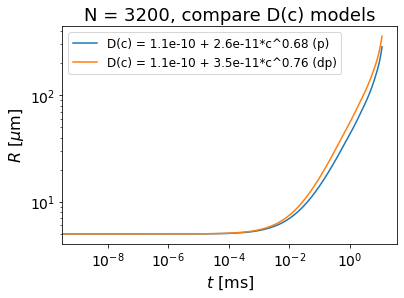

In [49]:
label_list = ['D(c) = {0:.2g} + {1:.2g}*c^{2:.2f} (p)'.format(D0, A_p, k_p),
              'D(c) = {0:.2g} + {1:.2g}*c^{2:.2f} (dp)'.format(D0, A_dp, k_dp)]

fig = plt.figure()
ax = fig.add_subplot(111)

for raw_vals, label in zip(raw_vals_list, label_list):
    _, _, t, R = raw_vals
    ax.plot(s_2_ms*(np.asarray(t) - t[0]), m_2_um*np.asarray(R), label=label)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$t$ [ms]', fontsize=ax_fs)
ax.set_ylabel(r'$R$ [$\mu$m]', fontsize=ax_fs)
ax.set_title('N = 3200, compare D(c) models', fontsize=t_fs)
ax.tick_params('both', labelsize=tk_fs)
ax.legend(fontsize=l_fs)

The difference is not negligible, but it might be small enough that downstream results are not affected qualitatively. I will plot the fractional difference between the predictions below.

(1e-06, 1)

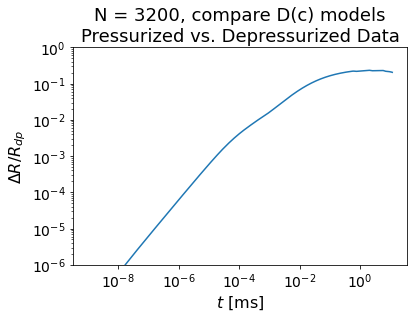

In [59]:
raw_vals_p, raw_vals_dp = raw_vals_list

_, _, t_p, R_p = raw_vals_p
_, _, t_dp, R_dp = raw_vals_dp

R_p_interp = np.interp(t_dp, t_p, R_p)
R_dp = np.asarray(R_dp)

R_frac_diff = np.abs(R_p_interp - R_dp) / R_dp

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(s_2_ms*(np.asarray(t_dp) - t_dp[0]), R_frac_diff)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$t$ [ms]', fontsize=ax_fs)
ax.set_ylabel(r'$\Delta R / R_{dp}$', fontsize=ax_fs)
ax.set_title('N = 3200, compare D(c) models\nPressurized vs. Depressurized Data', fontsize=t_fs)
ax.tick_params('both', labelsize=tk_fs)
ax.set_ylim([1E-6, 1])


The difference peaks around 30-40% about 1 ms after bubble nucleation. The discrepancy is certainly not negligible, but might not be so large that it affects our conclusions in later analysis.

## Couple Bubble Growth with Diffusion from Inner to Outer Stream

Now we set an initial condition with the saturation concentration of CO2 in the inner stream and no CO2 in the outer stream at the inlet. We allow the CO2 to diffuse into the outer stream as it flows down the channel until reaching the desired nucleation time. At that point, we simultaneously grow the bubble.

In this first version, we assume that the fluid around the bubble is incompressible and shifts outward as the bubble grows.

In [110]:
reload(polyco2)
reload(bubbleflow)

# simulation parameters
R_max = 150E-6
R_i = 40E-6
N0 = 50
D_max = D_p(500) # [m^2/s]
dt_sheath = 0.5*(R_max/N0)**2/D_max
half_grid = True
D_fn = D_p

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.sheath_incompressible(t_nuc, eps_params, R_max, N0, dc_c_s_frac, R_i,
                                                                         dt_sheath, half_grid=half_grid, D_fn=D_fn)

0% complete, t = 0.000 ms.
10% complete, t = 30.868 ms.
20% complete, t = 59.362 ms.
30% complete, t = 87.856 ms.
40% complete, t = 118.724 ms.
50% complete, t = 147.217 ms.
60% complete, t = 175.711 ms.
70% complete, t = 204.205 ms.
80% complete, t = 235.073 ms.
90% complete, t = 263.567 ms.


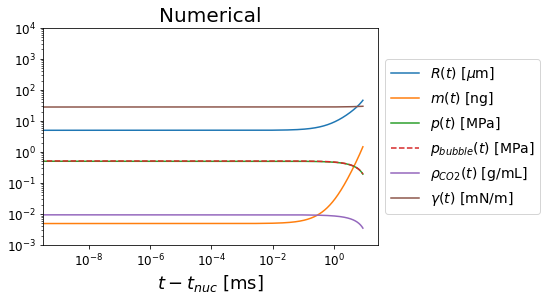

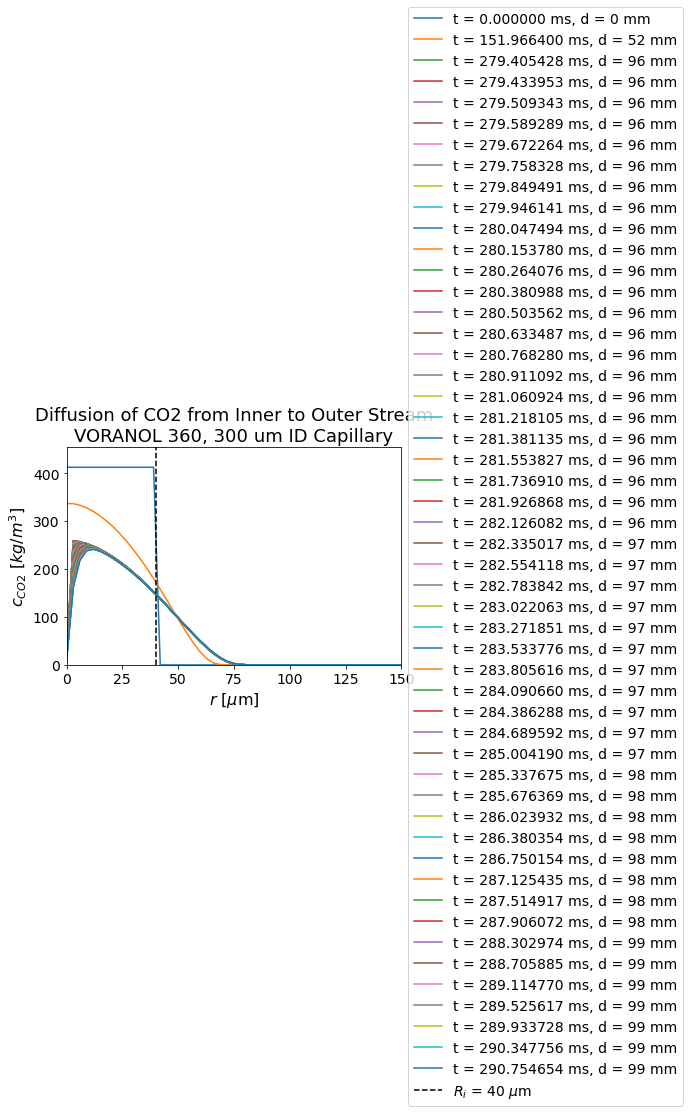

In [111]:
reload(pltd)
# plot
r_arr_list = [diffn.make_r_arr_lin(dr, R_max) for dr in dr_list]
n_plot = 50
ax1, ax2 = plot_bubble_sheath(R, m, p, p_bub, rho_co2, if_tension, t_num, t_nuc, t_flow, 
                              r_arr_list, c, R_max, v, c_bulk, n_plot, R_i=R_i)

### Fit to Bubble Growth

Now that I have coupled the inner and outer solutions, I will try to fit the result to our bubble growth profile.

In [7]:
R_nuc = 3E-8
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# global constants for diffusion model
filepath_D_c='../g-adsa_results/D_c_power_law.csv'
df_D = pd.read_csv(filepath_D_c)
D0, A_p, k_p = df_D['p']

eta_sd301 = 290
eta_v360 = 4815

A_p *= eta_sd301 / eta_v360
D0 *= eta_sd301 / eta_v360

def D_p(c):
    """
    Power-law fit for D(c) fitted to *pressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_p * c**k_p

reload(bubbleflow)
reload(an)
reload(diffn)
reload(bubble)
### LOADS BUBBLE DATA ###
# uses frames from video 20201010: v360_co2_c5_11184_010_050_0215_63_355_04_19.mp4
#***the inner stream in this video has 15-20% c5!
# frame rate [fps]
fps = 11184

# initial and final frames with bubbles (inclusive)
f_i = 9510
f_f = 9527
R_bubble = 8.5E-6 # bubble radius in first frame [m]
x_bubble = d # distance traveled along channel [m]
t_bubble = x_bubble / v # time bubble had traveled down channel [s]

# additional bubbles
f_bubbles = [i for i in range(f_i+1, f_f+1)]
R_bubbles = np.asarray([8.8, 8.8, 9, 9.8, 9.65, 10, 9.65, 10.15, 10.3, 10.3, 10.5, 11.15, 11.25, 
                      11.8, 11.55, 12.15, 12.8])/m_2_um
t_bubbles = np.asarray([t_bubble + (f - f_i)/fps for f in f_bubbles])

0% complete, t = 0.000 ms.
10% complete, t = 29.568 ms.
20% complete, t = 59.137 ms.
30% complete, t = 87.610 ms.
40% complete, t = 117.178 ms.
50% complete, t = 145.652 ms.
60% complete, t = 175.220 ms.
70% complete, t = 204.788 ms.
80% complete, t = 233.261 ms.
90% complete, t = 261.943 ms.
0% complete, t = 0.000 ms.
10% complete, t = 29.568 ms.
20% complete, t = 59.137 ms.
30% complete, t = 87.610 ms.
40% complete, t = 117.178 ms.
50% complete, t = 145.652 ms.
60% complete, t = 175.220 ms.
70% complete, t = 204.788 ms.
80% complete, t = 233.261 ms.
90% complete, t = 262.830 ms.
t_nuc = 270.000 ms and error in R is 0.3967.
0% complete, t = 0.000 ms.
10% complete, t = 29.568 ms.
20% complete, t = 59.137 ms.
30% complete, t = 87.610 ms.
40% complete, t = 117.178 ms.
50% complete, t = 145.652 ms.
60% complete, t = 175.220 ms.
70% complete, t = 204.788 ms.
80% complete, t = 233.261 ms.
90% complete, t = 262.830 ms.
t_nuc = 275.000 ms and error in R is 0.1767.
0% complete, t = 0.000 ms.
1

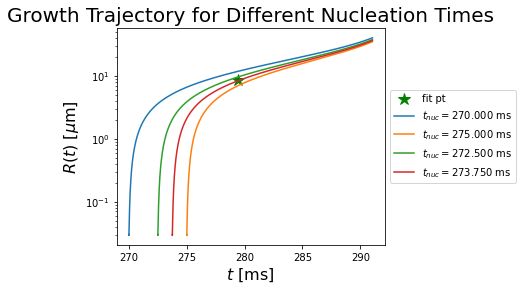

In [24]:
# fits results to bubble growth model
growth_fn = bubbleflow.sheath_incompressible
i_t = 2 # t_bub to match R
i_R = 10
sigma_R = 0.03 # tolerance of error in radius
# groups arguments for growth model
N = 200
D_max = D_p(500) # [m^2/s]
dt_sheath = 0.5*(R_max/N)**2/D_max
args = [eps_params, R_max, N, dc_c_s_frac, R_i, dt_sheath, D_p, True, 1, True]
i_t_nuc = 0

# increases maximum iterations
max_iter = 15

# bounds on nucleation time
t_nuc_lo = 0.26 # [s]
t_nuc_hi = 0.28 # [s]

# opens figure to show results of different guesses for bubble nucleation time
fig = plt.figure()
ax = fig.add_subplot(111)

# uses modified shooting method to estimate the nucleation time
t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                     i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R)

# unpacks output
t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
            rho_co2, v, dr_list = output
# groups results for plotting
props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

In [25]:
# groups results for plotting
props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

### Plot Results of Fitting Growth Function to Measured Bubble Size

Model prediction at fit point is R = 8.386591 um.


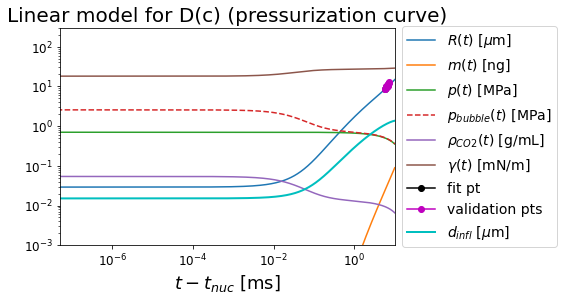

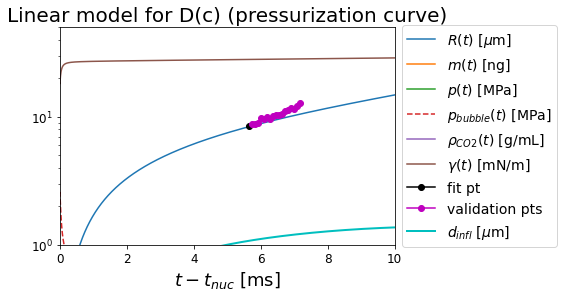

In [27]:
reload(pltb)
# log time axis
x_lim = [0.00000005, 10]
y_lim = [0.001, 300]
x_log = True
title = 'Linear model for D(c) (pressurization curve)'
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc, t_bubble, t_bubbles, R_bubble, R_bubbles, t_R=(t_bub, props_list_fit[0]))
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])
pltg.legend(ax)

# linear time axis
x_lim = [0.0, 10]
y_lim = [1, 50]
x_log = False
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc, t_bubble, t_bubbles, R_bubble, R_bubbles)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])

pltg.legend(ax)

Discrepancy could be due to presence of cyclopentane, which will likely increase diffusivity and bubble growth.

### Try with different bubble 

Since the model successfully captured the growth of the previous bubble, I will test if it can capture the growth of another bubble. This time, the bubble will be growing in an inner stream of VORANOL 360 + CO2 (no cyclopentane). The bubble was observed in the video `v360_co2_8987_017_050_0200_94_295_04_7.mp4` recorded on August 29, 2020, in frames 12898-12921.

In [35]:
eta_i = 0.20 # [Pa.s] see 20200829_v360_co2_80bar_flow_props.ipynb
Q_i = 50 # [uL/min]
Q_o = 200 # [uL/min]
p_s = 80E5 # [Pa] 80 bar saturation
dp = 89E5 # [Pa] see 20200829_v360_co2_80bar_flow_props.ipynb
d = 0.094 # [m]
# computes inner stream radius [m] and velocity [m/s]
_, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM  dp
R_nuc = 1E-6 # [m]

# parameters for Epstein-Plesset model
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)


fps = 8987

# initial and final frames with bubbles
f_i = 12898
f_f = 12921
R_bubble = 4E-6 # bubble radius in first frame [m]
x_bubble = d # distance traveled along channel [m]
t_bubble = x_bubble / v # time bubble had traveled down channel [s]
print(t_bubble)

# additional bubbles
f_bubbles = [i for i in range(f_i+1, f_f+1)]
R_bubbles = np.array([7.8, 9, 9.2, 11, 12, 13.5, 15, 16, 17.7, 19, 20, 20, 21, 21.4, 22.4, 24, 25, 26, 27, 29.5, 28.5, 30.5, 
             32.3])/m_2_um
t_bubbles = [t_bubble + (f - f_i)/fps for f in f_bubbles]

0.3539553089285926


0% complete, t = 0.000 ms.
10% complete, t = 36.139 ms.
20% complete, t = 72.278 ms.
30% complete, t = 107.322 ms.
40% complete, t = 143.461 ms.
50% complete, t = 178.505 ms.
60% complete, t = 213.853 ms.
70% complete, t = 249.495 ms.
80% complete, t = 285.159 ms.
90% complete, t = 320.817 ms.
Predicted bubble radius is smaller than fit for lowest nucleation time. Terminating early.


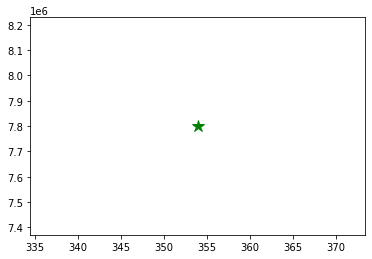

In [36]:
### CURRENTLY FAILS DUE TO ADAPTIVE TIME STEPPING--STUCK IN INFINITE LOOP ###

reload(bubble)
reload(bubbleflow)

# fits results to bubble growth model
growth_fn = bubbleflow.sheath_incompressible
i_t = 2 # t_bub to match R
i_R = 10
sigma_R = 0.03 # tolerance of error in radius
# groups arguments for growth model
N = 200
D_max = D_p(500) # [m^2/s]
dt_sheath = 0.5*(R_max/N)**2/D_max
args = [eps_params, R_max, N, dc_c_s_frac, R_i, dt_sheath, D_p, True, 1, True]
dict_args = {'t_f' : t_bubbles[-1]}
i_t_nuc = 0

# increases maximum iterations
max_iter = 15

# bounds on nucleation time
t_nuc_lo = 0.2 # [s]
t_nuc_hi = 0.352 # [s]

# opens figure to show results of different guesses for bubble nucleation time
fig = plt.figure()
ax = fig.add_subplot(111)

# uses modified shooting method to estimate the nucleation time
t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                     i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

# unpacks output
t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
            rho_co2, v, dr_list = output
# groups results for plotting
props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

In [37]:
# groups results for plotting
props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

Plot results.

Model prediction at fit point is R = 13.267412 um.


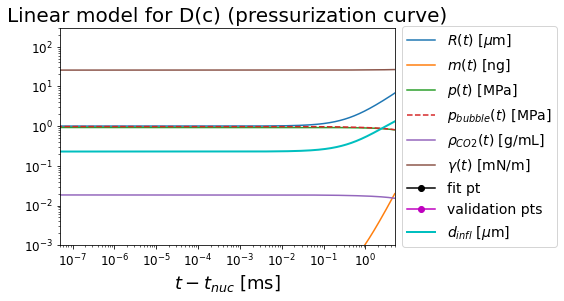

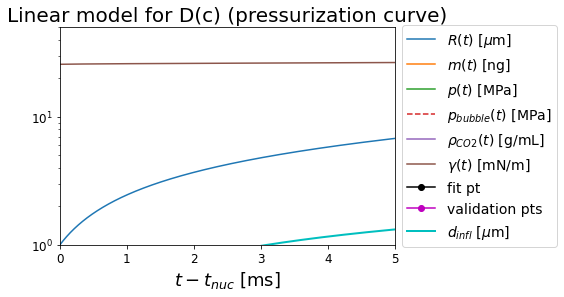

In [31]:
t_bubbles = np.asarray(t_bubbles)
reload(pltb)
# log time axis
x_lim = [0.00000005, 5]
y_lim = [0.001, 300]
x_log = True
title = 'Linear model for D(c) (pressurization curve)'
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc, t_bubble, np.asarray(t_bubbles), R_bubble, R_bubbles, t_R=(t_bub, props_list_fit[0]))
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])
pltg.legend(ax)

# linear time axis
x_lim = [0.0, 5]
y_lim = [1, 50]
x_log = False
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc, t_bubble, t_bubbles, R_bubble, R_bubbles)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])

pltg.legend(ax)